cut down to five years and plot feature importance

In [58]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling, over_sampling 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import cross_val_score


%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_columns',500)
sns.set()

import random

SEED = 27
random.seed(SEED)
np.random.seed(SEED)


In [68]:
p = Path.cwd()
data_path = p.parent.parent / 'data' / 'Master Project Data' 
nfirs_path =  data_path / 'NFIRS Fire Incident Data.csv'

# List the columns you want to download from the NFIRS csv
cols_to_use = ['state','fdid','inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','geoid']

# Specify particular data type for geoid column
col_dtypes = {'geoid':str}

# Read in NFIRS dataframe
nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

# Convert inc_date column values to python datetime type
nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)



#Read in ACS dataframe
ACS_path = data_path  / 'ACS 5YR Block Group Data.csv'
ACS = pd.read_csv(ACS_path,
                  dtype = {'GEOID':'object'},
                  index_col = 1)
            

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
preprocessed_acs_shape = ACS.shape
preprocessed_acs_shape

(217739, 115)

In [69]:
#NFIRS Munging

# Ensure correct calculation of tot_loss column 
nfirs['tot_loss'] = nfirs['prop_loss'] + nfirs['cont_loss']

# Create mask for new death or injuries variable
death_inj_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0)

# By default assigns values of death or injuries column as not severe
nfirs['had_death_injury'] = 'no_death_injury'

# Applies filter to death or injuries column to label the death or injuries instances correctly
nfirs.loc[death_inj_mask,'had_death_injury'] = 'had_death_injury'

# Create new NFIRS variables based on specified thresholds of existing variables in dataframe
nfirs['had_inj'] = np.where(nfirs['oth_inj']>0,'had_inj','no_inj')
nfirs['had_death'] = np.where(nfirs['oth_death']>0,'had_death','no_death')

# Extract just the numeric portion of the geoid
nfirs['geoid'] =  nfirs['geoid'].str[2:-1] 
nfirs =  nfirs[~ nfirs['geoid'].isna()]

# Add a year column to be used to groupby in addition to geoid
nfirs['year'] = nfirs['inc_date'].dt.year.astype('str')
# nfirs.set_index('geoid',inplace = True)


In [78]:
nfirs.groupby(['geoid']).fdid.nunique().describe()

count    70272.000000
mean         2.862363
std         56.202352
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max      14895.000000
Name: fdid, dtype: float64

In [5]:
# ACS Munging

# Ensures GEOID variable is in the correct format and sets it as the dataframe index
ACS['GEOID'] = ACS['GEOID'].str[2:-1]   
ACS.set_index(['GEOID'],inplace = True)

# Removes extraneous columns in the dataframe
if 'Unnamed: 0' in ACS.columns:
    ACS.drop('Unnamed: 0','columns',inplace= True)

if 'NAME' in ACS.columns:
    ACS.drop('NAME','columns',inplace= True)

if 'inc_pcincome' in ACS.columns:
    ACS.drop('inc_pcincome','columns',inplace= True)

# Creates vector of total populations for each census tract to be used to normalize total fires per year variable
tot_pop = ACS[['tot_population']].groupby('GEOID').sum()

# Drop all total count columns in ACS and keeps all percentage columns
cols = ACS.columns.to_list()
for col in cols:
    if  col.find('tot') != -1: 
        ACS.drop(col,'columns', inplace = True)

# Integer indexing for all rows, but gets rid of county_name, state_name, and in_poverty       
ACS = ACS.iloc[:,3:]
ACS = ACS.groupby('GEOID').mean()

# Remove missing values from dataframe
ACS.replace([np.inf, -np.inf], np.nan,inplace = True)
ACS.dropna(inplace = True)


In [6]:
# Check portions of ACS used after cleaning
postprocessed_acs_shape = ACS.shape
print(f"{round((postprocessed_acs_shape[0]/preprocessed_acs_shape[0]) * 100, 1)}% of the ACS data eligible to merge ({postprocessed_acs_shape[0]} rows)")

33.0% of the ACS data eligible to merge (71865 rows)


In [7]:
## Adjust total fires per year by the population counts

# Drop fires without fatalities
# nfirs_mort = nfirs.loc[nfirs['had_death'] == "had_death"]

# Creates dataframe that shows the number of deaths in each census block each year
fires = pd.crosstab(nfirs.index, nfirs['had_death_injury'])
fires.index.rename('GEOID',inplace = True)

# Grab total population values pulled from ACS dataframe and assign to each census block in NFIRS dataframe
fires = fires.merge(tot_pop, how = 'left', left_index = True, right_index = True)

# Remove resulting NaN/infinity values following merge
fires.replace([np.inf, -np.inf], np.nan,inplace = True)
fires.dropna(inplace = True)

# drop rows with no population count
fires = fires[fires['tot_population'] != 0 ]

# population adjustment
fires = fires.div(fires['tot_population'], axis = 'index')*1000
# fires = fires.loc[:,:'2016']

# view fires by year across geoids; displays additional information regarding # of fires in higher percentile categories
fires.describe(percentiles=[.75, .85, .9 ,.95, .99])
print(fires)

             had_death_injury  no_death_injury  tot_population
GEOID                                                         
01001020100          0.000000         7.046070          1000.0
01001020200          1.014199         9.127789          1000.0
01001020300          0.590842         7.090103          1000.0
01001020400          0.000000         5.155847          1000.0
01001020500          0.204939         5.738293          1000.0
...                       ...              ...             ...
56043000200          0.000000         1.596424          1000.0
56043000301          0.827130         4.962779          1000.0
56043000302          0.000000         1.970832          1000.0
56045951100          0.000000         1.312336          1000.0
56045951300          0.000000         2.425876          1000.0

[70189 rows x 3 columns]


In [8]:
# drop unused variables
fires = fires.drop(columns=['no_death_injury', 'tot_population'])

# define variables to indicate census blocks in the top 10% percent of fire risk scores
top10 = fires > fires.quantile(.9)

In [9]:
fires.describe()

,had_death_injury
count,70189.000000
mean,0.181631
std,0.358259
min,0.000000
25%,0.000000
50%,0.000000
75%,0.262674
max,24.390244


In [10]:
# function to create histogram of with # of fires on x-axis and # of census blocks on y-axis
def plotFires(df):

    figsize = (20, 16)
    cols = 4
    rows = 2
    f, axs = plt.subplots(cols,rows,figsize= figsize)


    cases = df.columns.to_list()
    for  case in enumerate(cases):
        ax = plt.subplot(cols,rows,case[0]+1)
        ax.set_title('All Fires {}'.format(str(case[1])) )
        plt.hist(df[case[1]],bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,20,40,80,100])


                     Pair Var 1                    Pair Var 2  Corr Value
70         house_pct_non_family          house_pct_live_alone    0.923510
32               race_pct_white              race_pct_whitenh    0.860129
43            race_pct_nonwhite           race_pct_nonwhitenh    0.860129
127  house_pct_incomplete_plumb  house_pct_incomplete_kitchen    0.834645
122    house_pct_complete_plumb    house_pct_complete_kitchen    0.834645
44            race_pct_nonwhite                race_pct_black    0.807319
56             house_pct_family      house_pct_family_married    0.785545
21               educ_bachelors                  educ_masters    0.766958
63     house_pct_family_married       house_pct_ownd_occupied    0.753795
7                  educ_5th_6th                 race_pct_hisp    0.739618
87      house_pct_rent_occupied              house_pct_3_room    0.719568
83      house_pct_ownd_occupied              house_pct_3_room   -0.719568
15        educ_high_school_grad       

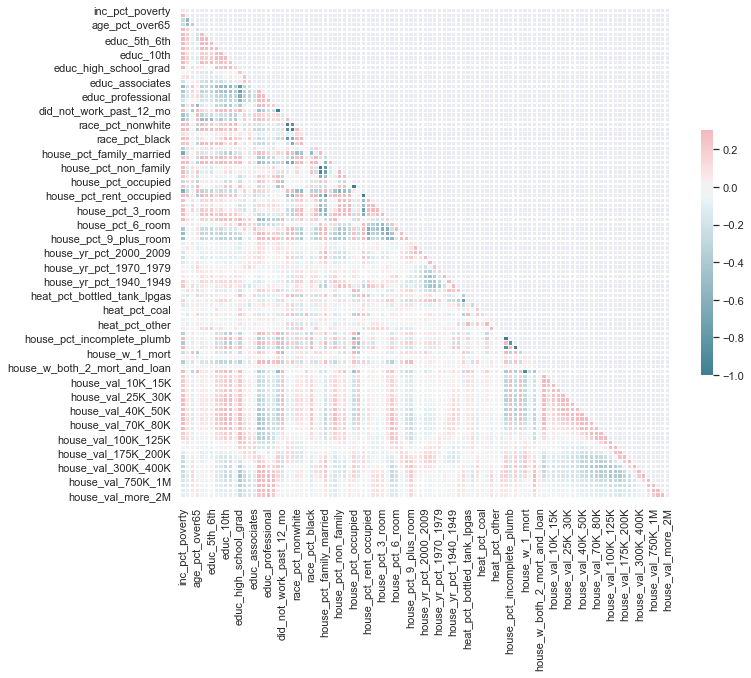

In [11]:
# Find correlated features in ACS dataset and identify the highly correlated relationships

# Based on feature importance experiments, select features with consistence importance across annual predictions

# Create ACS correlation matrix
corr = ACS.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
# Filtering out lower/upper triangular duplicates 
corr_high = corr[abs(corr) > 0.7].stack().reset_index()
corr_high = corr_high[corr_high['level_0'].astype(str)!=corr_high['level_1'].astype(str)]
corr_high['ordered-cols'] = corr_high.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
corr_high = corr_high.drop_duplicates(['ordered-cols'])
corr_high.drop(['ordered-cols'], axis=1, inplace=True)
corr_high.columns = ['Pair Var 1', 'Pair Var 2', 'Corr Value']

# Display highly correlated pairs
print(corr_high.sort_values(by=['Corr Value'], ascending=False))

# From highly correlated pairs, remove one of the Pair Vars from the ACS dataset except for the 'mort' variables
ACS = ACS.drop(['house_pct_vacant', 'did_not_work_past_12_mo', 'house_pct_non_family', 'house_pct_rent_occupied',
                           'race_pct_nonwhite', 'race_pct_nonwhitenh', 'house_pct_incomplete_plumb',
                           'house_pct_incomplete_kitchen', 'race_pct_whitenh'], axis=1) 

# Based on feature importance experiments, select features with consistent importance across annual predictions
ACS = ACS[['house_yr_pct_earlier_1939', 'house_pct_occupied', 'house_pct_family_married', 'race_pct_black',
          'worked_past_12_mo', 'heat_pct_fueloil_kerosene', 'educ_bachelors', 'house_pct_live_alone', 
          'educ_some_col_no_grad', 'house_pct_ownd_occupied', 'house_w_home_equity_loan', 'house_val_175K_200K',
           'house_val_200K_250K']]


In [12]:
# Function to upsample or downsample our dataframe features if we have unbalanced classes

def resample_df(X,y,upsample=True,seed = SEED):
    from sklearn.utils import resample
    # check which of our two classes is overly represented 
    if np.mean(y) > .5:
        major,minor = 1,0
    else:
        major,minor = 0, 1
    
    # Add Class feature to dataframe equal to our existing dependent variable
    X['Class'] = y
    
    df_major = X[X.Class == major ]
    df_minor = X[X.Class == minor ]
    

    if upsample:      
    
        df_minor_resampled = resample(df_minor,
                                     replace = True,
                                     n_samples = df_major.shape[0], 
                                     random_state = seed)
    
    
   
        combined = pd.concat([df_major,df_minor_resampled])
        
        # Debug
        #print('minor class {}, major class {}'.format(df_minor_resampled.shape[0],
                                                       #df_major.shape[0]))
    
        
    else: # downsample
         
        df_major_resampled = resample(df_major,
                                     replace = False,
                                     n_samples = df_minor.shape[0],
                                     random_state = seed)
        
        
        combined = pd.concat([df_major_resampled,df_minor])
        
        #print('minor class {}, major class {}'.format(df_minor.shape[0],
                                                      #df_major_resampled.shape[0]))


    
    
    y_out = combined['Class']
    X_out = combined.drop('Class', axis =1)
    return X_out , y_out

In [13]:
top10.mean()

had_death_injury    0.100001
dtype: float64

In [39]:
# Function to train model that predicts whether each census block is in the top 10% percent of fire risk scores
def train_model(top10, fires, ACS = pd.DataFrame(), nyears = 4, modeltype='LogisticRegression', resample = False, seed = SEED):
    from scipy.stats import zscore
    
    
    # Define model types & parameters 
    
    if modeltype =='LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(warm_start=True,
                                   class_weight = 'balanced',
                                   max_iter = 1000)

        
    elif modeltype =='BalBagged':
        from imblearn.ensemble import BalancedBaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                          n_estimators=80, sampling_strategy='auto',
                                          random_state=0)
        
    elif modeltype =='BalRF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=80, sampling_strategy='auto',
                                               max_depth=10, random_state=0,
                                              max_features=None, min_samples_leaf=40)

    elif modeltype =='Bagged':
        from sklearn.ensemble import BaggingClassifier
        from sklearn.tree import DecisionTreeClassifier
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    n_estimators=40,
                                    random_state=0)
    
    elif modeltype =='RF':
        from imblearn.ensemble import BalancedRandomForestClassifier
        model = BalancedRandomForestClassifier(n_estimators=60,
                                          warm_start = False,
                                          max_depth = 10,
                                            random_state = 0)
    elif modeltype =='RFtest':
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=60, class_weight = "balanced", max_depth = 10 )
        
    elif modeltype =='LightGBM':
        import lightgbm as lgb 
        model = RandomForestClassifier(n_estimators=60, class_weight = "balanced", max_depth = 10 )
    
    
    # Create framework to predict whether a given census block has a fire risk score in the 90th percentile 
    # based on the specific number of previous years' data
        
#     years = top10.columns
       
#         X = fires.iloc[:,X_start:X_end].copy()
    X = fires.copy()

#     L = X.shape[1] 
#     X.columns = ['year-{}'.format(L - year) for year in range(L)]
#     sm = np.sum(X, axis = 1 )
#     mu = np.mean(X, axis = 1)
#     mx = np.max(X, axis =1)
#     X['Sum']  = sm
#     X['Mean'] = mu
#     X['Max']  = mx
    # set y to target variable
    y = top10.had_death_injury

    # merge in ACS Data into X unless NFIRS-Only model
    if not ACS.empty:
#         X = X[['Sum','Mean','Max']] # drop all other NFIRS columns that have low feature importance scores
        X = X.merge(ACS, how ='left',left_index = True, right_index = True)
        X = X.dropna()
        # drop target variable
        X = X.drop(columns="had_death_injury")
        y = y[y.index.isin(X.index)]
        print(f"X.shape: {X.shape}, y.shape: {y.shape}")



    # Create 80/20 training/testing set split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2 )

    # Perform resampling if data classes are unbalanced
    if resample:
        X_train, y_train = resample_df(X_train,y_train)


    # Perform cross-validation 

    #scaler = preprocessing.StandardScaler().fit(X)
    #scaler.transform(X)
    #print ('Cross Val Score:')
    #print(cross_val_score(model, X, y))


    # Standardize features by removing the mean and scaling to unit variance

    scaler = preprocessing.StandardScaler().fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)


    # Fit model to training set

    print('Predicting')
    model = model.fit(X_train,y_train)

    # Calculate training set performance

    train_prediction_probs = model.predict_proba(X_train)
    train_predictions = model.predict(X_train)
    print (confusion_matrix(y_train, train_predictions))
    print (plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Oranges, values_format=''))
    print (roc_auc_score(y_train, train_prediction_probs[:,1]))


    # Calculate test set performance

    test_prediction_probs = model.predict_proba(X_test)
    test_predictions = model.predict(X_test)
    print (confusion_matrix(y_test, test_predictions))
    print (plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format=''))
    print (roc_auc_score(y_test, test_prediction_probs[:,1]))
    print (classification_report(y_test,test_predictions))
    print (log_loss(y_test,test_predictions))


    #Calculate feature importance for each model

    if modeltype=="LogisticRegression":
        feature_importance = {}
        for coef, feat in zip(abs(model.coef_[0]),X_test.columns.tolist()):
            feature_importance[feat] = coef
        print("Feature ranking:")
        print (feature_importance)
    else:
        if modeltype=="RFtest" or modeltype=="BalRF":
            importances = model.feature_importances_
        elif modeltype=="Bagged":
            importances = np.mean([model.estimators_[i].feature_importances_ for i 
                           in range(len(model.estimators_))], axis=0)
        elif modeltype=="BalBagged":
            importances = np.mean([model.estimators_[i].steps[1][1].feature_importances_ for i 
                           in range(len(model.estimators_))], axis=0)

        indices = np.argsort(importances)[::-1]
        print("Feature ranking:")
        for f in range(len(X_test.columns)):
            print("%d. %s (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))

    # Increment sliding prediction window
    #start_pointer += 1
#     end_pointer += 1
#     y_pointer += 1

    
            
    return model, X_test, y_test
        


In [36]:
69945/postprocessed_acs_shape[0]

0.9732832394072218

X.shape: (69945, 13), y.shape: (69945,)
Predicting
[[35244 15124]
 [ 1807  3781]]
0.7506062608976032
[[8868 3716]
 [ 458  947]]
0.7503961987543354
              precision    recall  f1-score   support

       False       0.95      0.70      0.81     12584
        True       0.20      0.67      0.31      1405

    accuracy                           0.70     13989
   macro avg       0.58      0.69      0.56     13989
weighted avg       0.88      0.70      0.76     13989

10.305799126199712
Feature ranking:
{'house_yr_pct_earlier_1939': 0.8711946109154195, 'house_pct_occupied': 1.2523664445371268, 'house_pct_family_married': 3.740802417671586, 'race_pct_black': 0.582642046938512, 'worked_past_12_mo': 0.6120913025150656, 'heat_pct_fueloil_kerosene': 0.008748074910060702, 'educ_bachelors': 3.2139426333860097, 'house_pct_live_alone': 1.74990371767009, 'educ_some_col_no_grad': 0.6051260494535962, 'house_pct_ownd_occupied': 0.6383164787217627, 'house_w_home_equity_loan': 0.3056383787619502, 'h

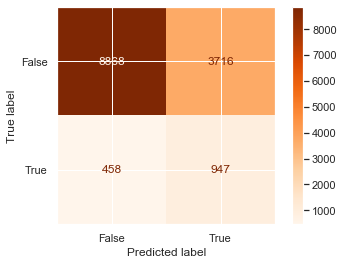

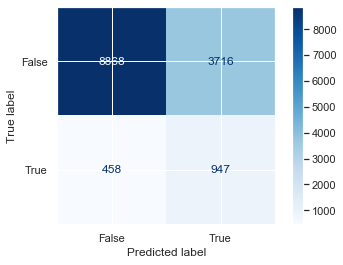

In [37]:
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl, X_test, y_test = train_model(top10, fires, ACS = ACS, nyears=1, modeltype='LogisticRegression', resample = False)

X.shape: (69945, 13), y.shape: (69945,)
Predicting
[[42405  7973]
 [ 1425  4153]]
0.8819897231287864
[[10388  2186]
 [  659   756]]
0.7654322312967304
              precision    recall  f1-score   support

       False       0.94      0.83      0.88     12574
        True       0.26      0.53      0.35      1415

    accuracy                           0.80     13989
   macro avg       0.60      0.68      0.61     13989
weighted avg       0.87      0.80      0.83     13989

7.024416810601423
Feature ranking:
1. house_pct_family_married (0.216390)
2. race_pct_black (0.112434)
3. house_pct_ownd_occupied (0.108015)
4. house_pct_occupied (0.095035)
5. house_pct_live_alone (0.089439)
6. educ_bachelors (0.083517)
7. house_yr_pct_earlier_1939 (0.062361)
8. house_val_200K_250K (0.049290)
9. worked_past_12_mo (0.042792)
10. educ_some_col_no_grad (0.038951)
11. house_val_175K_200K (0.038801)
12. house_w_home_equity_loan (0.033748)
13. heat_pct_fueloil_kerosene (0.029227)


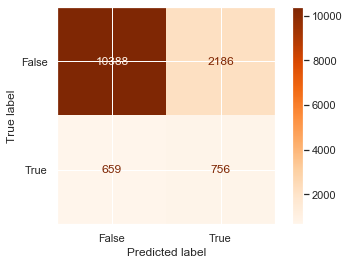

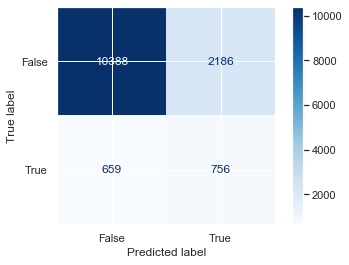

In [40]:
%%time
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl, X_test, y_test = train_model(top10, fires, ACS = ACS, nyears=1, modeltype='RFtest', resample = False)

X.shape: (69945, 13), y.shape: (69945,)
Predicting
[[50249     1]
 [   63  5643]]
0.9999996460041188
[[12599   103]
 [ 1215    72]]
0.7367575565497153
              precision    recall  f1-score   support

       False       0.91      0.99      0.95     12702
        True       0.41      0.06      0.10      1287

    accuracy                           0.91     13989
   macro avg       0.66      0.52      0.52     13989
weighted avg       0.87      0.91      0.87     13989

3.254141800488069
Feature ranking:
1. house_pct_family_married (0.135063)
2. house_pct_occupied (0.091400)
3. educ_bachelors (0.090407)
4. house_pct_live_alone (0.080291)
5. house_yr_pct_earlier_1939 (0.079309)
6. house_pct_ownd_occupied (0.078174)
7. race_pct_black (0.074711)
8. educ_some_col_no_grad (0.074468)
9. worked_past_12_mo (0.073403)
10. house_val_200K_250K (0.063018)
11. house_w_home_equity_loan (0.061689)
12. house_val_175K_200K (0.056480)
13. heat_pct_fueloil_kerosene (0.041587)
Wall time: 57.5 s


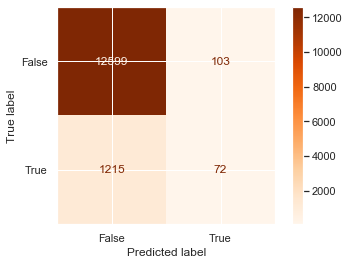

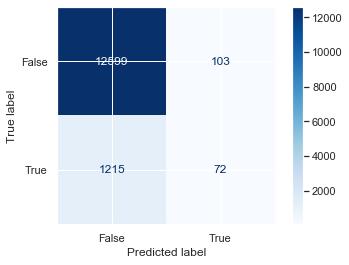

In [41]:
%%time
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl, X_test, y_test = train_model(top10, fires, ACS = ACS, nyears=1, modeltype='Bagged', resample = False)

X.shape: (69945, 13), y.shape: (69945,)
Predicting


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, cate

[[44246  6180]
 [    0  5530]]
0.9936389358685698
[[10391  2135]
 [  684   779]]
0.7553979042798089
              precision    recall  f1-score   support

       False       0.94      0.83      0.88     12526
        True       0.27      0.53      0.36      1463

    accuracy                           0.80     13989
   macro avg       0.60      0.68      0.62     13989
weighted avg       0.87      0.80      0.83     13989

6.960220015566994
Feature ranking:
1. house_pct_family_married (0.214166)
2. house_pct_occupied (0.083146)
3. educ_bachelors (0.083045)
4. house_pct_live_alone (0.073168)
5. house_pct_ownd_occupied (0.071217)
6. race_pct_black (0.070790)
7. educ_some_col_no_grad (0.066970)
8. house_yr_pct_earlier_1939 (0.066887)
9. worked_past_12_mo (0.063811)
10. house_val_200K_250K (0.059703)
11. house_w_home_equity_loan (0.057052)
12. house_val_175K_200K (0.053987)
13. heat_pct_fueloil_kerosene (0.036057)
Wall time: 33.1 s


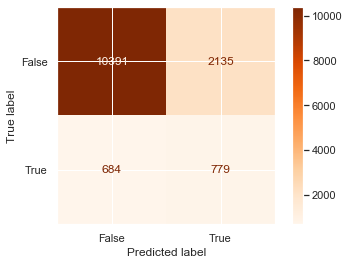

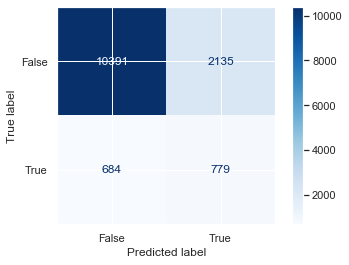

In [42]:
%%time
# Train NFIRS Only Model and output prediction performance metrics for each year
# mdl,X_test,y_test=train_model(top10.loc[:,'2009':'2016'],fires,nyears = 5, modeltype='RF', resample = True)

# Train NFIRS + ACS Model and output prediction performance metrics for each year
mdl, X_test, y_test = train_model(top10, fires, ACS = ACS, nyears=1, modeltype='BalBagged', resample = False)

### Model Tuning

In [16]:
X = fires.copy()
y = top10.had_death_injury
X = X.merge(ACS, how ='left',left_index = True, right_index = True)
X = X.dropna()
X = X.drop(columns="had_death_injury")
y = y[y.index.isin(X.index)]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

In [19]:
def search_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='average_precision',
                       do_probabilities = False, search_mode = 'GridSearchCV', n_iterations = 0):
    fitted_model = None
    
    if(search_mode == 'GridSearchCV'):
        gs = GridSearchCV(
            estimator=model,
            param_grid=param_grid, 
            cv=cv, 
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = gs.fit(X_train_data, y_train_data)

    elif (search_mode == 'RandomizedSearchCV'):
        rs = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid, 
            cv=cv,
            n_iter=n_iterations,
            n_jobs=-1, 
            scoring=scoring_fit,
            verbose=2
        )
        fitted_model = rs.fit(X_train_data, y_train_data)
    
    
    if(fitted_model != None):
        if do_probabilities:
            pred = fitted_model.predict_proba(X_test_data)
        else:
            pred = fitted_model.predict(X_test_data)
            
        return fitted_model, pred

In [53]:
%%time

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 5]
}

model, pred = search_pipeline(X_train, X_test, y_train, y_test, model, 
                              param_grid, cv=5, search_mode='RandomizedSearchCV', n_iterations = 8)

print(model.best_score_)
print(model.best_params_)

NameError: name 'RandomizedSearchCV' is not defined

In [44]:
fires.had_death_injury.mean()

0.1816314721335135

In [ ]:
!pip list

In [72]:
%%time

import lightgbm as lgb 
# try wildcard lightGBM model (similar but faster boosted tree ensemble)
model = lgb.LGBMClassifier()
param_grid = {
    'n_estimators': [400, 250, 100],
    'colsample_bytree': [0.9, 0.8],
    'max_depth': [100,50,25],
    'num_leaves': [75, 100, 125],
    'reg_alpha': [1.7, 1.5, 1.3],
    'reg_lambda': [1.2],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.75, 0.8, 0.85],
    'subsample_freq': [15, 25],
    'scale_pos_weight': [82]
}

model, pred = search_pipeline(X_train, X_test, y_train, y_test, model, 
                              param_grid, cv=5, search_mode='RandomizedSearchCV',
                              scoring_fit='balanced_accuracy', n_iterations = 8)

print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished


0.679255470542367
{'subsample_freq': 25, 'subsample': 0.85, 'scale_pos_weight': 82, 'reg_lambda': 1.2, 'reg_alpha': 1.3, 'num_leaves': 75, 'n_estimators': 250, 'min_split_gain': 0.3, 'max_depth': 100, 'colsample_bytree': 0.8}
Wall time: 3min 23s


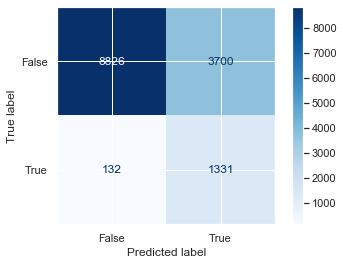

In [73]:
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format='');

In [74]:
    test_prediction_probs = model.predict_proba(X_test)
    test_predictions = model.predict(X_test)
    print (roc_auc_score(y_test, test_prediction_probs[:,1]))
    print (classification_report(y_test,test_predictions))
    print (log_loss(y_test,test_predictions))

0.9188811264367791
              precision    recall  f1-score   support

       False       0.99      0.70      0.82     12526
        True       0.26      0.91      0.41      1463

    accuracy                           0.73     13989
   macro avg       0.62      0.81      0.62     13989
weighted avg       0.91      0.73      0.78     13989

9.461401791106546


In [ ]:
model.plot_importance()

In [49]:
import joblib

In [51]:
joblib.dump(model, "95_recall_lightgbm.pkl")

['95_recall_lightgbm.pkl']

{'subsample_freq': 25, 'subsample': 0.8, 'scale_pos_weight': 82, 'reg_lambda': 1.2, 'reg_alpha': 1.5, 'num_leaves': 100, 'n_estimators': 100, 'min_split_gain': 0.3, 'max_depth': 100, 'colsample_bytree': 0.8} .95 recall